# FEATURE ENGINEERING OPERATIONS - {"BIGMART SALES" DATASET}

## 1. Importing Modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.pipeline import Pipeline

In [2]:
# PD Options

pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 4)

In [3]:
# SB Options

sb.set_theme(context='notebook', style='whitegrid', palette='pastel', font='times new roman', font_scale=1.25)

## 2. Importing Dataset

### 2.1 Train Dataset

In [4]:
tr = pd.read_pickle('bms_train_pp.pkl')

print(f'Shape of the train dataset : {tr.shape}')
tr.head(5)

Shape of the train dataset : (8323, 14)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Category,Outlet_Age
2171,FDP28,13.65,Regular,0.0808,Frozen Foods,262.8936,OUT049,1999,Medium,Tier 1,Supermarket Type1,4958.8784,Foods,14
5657,FDK14,6.98,Low Fat,0.0412,Canned,82.8934,OUT045,2002,Small,Tier 2,Supermarket Type1,818.9340,Foods,11
2156,FDX50,20.10,Low Fat,0.0746,Dairy Foods,110.3228,OUT046,1997,Small,Tier 1,Supermarket Type1,1768.3648,Foods,16
110,FDD03,13.30,Low Fat,0.0798,Dairy Foods,232.5300,OUT046,1997,Small,Tier 1,Supermarket Type1,699.0900,Foods,16
6709,NCV05,10.10,Non Edible,0.0301,Health and Hygiene,154.3656,OUT027,1985,Medium,Tier 3,Supermarket Type3,2471.4496,Non Consumables,28


In [5]:
Xtr = tr.drop(columns='Item_Outlet_Sales')
ytr = tr['Item_Outlet_Sales']

In [6]:
Xtr = Xtr.drop(columns=['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'])
Xtr.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age
2171,13.65,Regular,0.0808,Frozen Foods,262.8936,Medium,Tier 1,Supermarket Type1,Foods,14
5657,6.98,Low Fat,0.0412,Canned,82.8934,Small,Tier 2,Supermarket Type1,Foods,11
2156,20.10,Low Fat,0.0746,Dairy Foods,110.3228,Small,Tier 1,Supermarket Type1,Foods,16
110,13.30,Low Fat,0.0798,Dairy Foods,232.5300,Small,Tier 1,Supermarket Type1,Foods,16
6709,10.10,Non Edible,0.0301,Health and Hygiene,154.3656,Medium,Tier 3,Supermarket Type3,Non Consumables,28


## 3. Feature Engineering Process

### 3.1 Outliers Detection (IQR) and Handling (Capping)
##### - Outlier detection and handling is applied only on training data.
##### - Operation is not applied on the validation and test data, to avoid the changes in the data. Considering that the prediction is applied on individual basis, one at a time. So, no point of finding IQR and applying capping. 

In [7]:
def outliers_detect_handle(df):
     
    fea_flo = df.select_dtypes(include='float').columns.values.tolist()
    fea_int = df.select_dtypes(include='int').columns.values.tolist()

    fea_num = fea_flo + fea_int
    fea_num
    
    # OUTLIER DETECTION CODE ----------------------------------------------------------------------------------------------
    
    for fea in fea_num:
      
        print(f'Outlier Detection for Feature : {fea} \n')
        
        print('Outliers Summary ........................................................... \n')
        mn = df[fea].min()
        mx = df[fea].max()
        print(f'Minimum Value : {mn} and Maximum Value : {mx} \n')

        q1,q3 = df[fea].quantile([0.25,0.75])         #  for 1st and 3rd quartile
        print(f'1st Quartile : {q1} and 3rd Quartile : {q3} \n')

        lb = round(q1 - (q3-q1)*1.5,4)
        ub = round(q3 + (q3-q1)*1.5,4)
        print(f'Lower Bound : {lb} and Higher Bound : {ub} \n')

        filtl = df[fea] < lb
        out_low = df[filtl]
        print(f'No. of Outliers below Lower Bound ({lb}) are : {out_low.shape[0]}')

        filtu = df[fea] > ub
        out_high = df[filtu]
        print(f'No. of Outliers above Upper Bound ({ub}) are : {out_high.shape[0]}')

        out_df = df[(filtl | filtu)]
        print(f'Total No. of Outliers are : {out_df.shape[0]} \n')

        per = (out_df.shape[0]/df[fea].shape[0])*100
        print(f'Percentage of Outliers Records are : {round(per,4)} % \n')

        plt.figure(figsize=(15,5))
        plt.subplot(2,2,1)
        plt.title('KDE Plot Before')
        sb.kdeplot(data=df, x=fea)

        plt.subplot(2,2,2)
        plt.title('BOX Plot Before')
        sb.boxplot(data=df, x=fea)
        
        print('Outliers after Detection and Handling ....................................... \n')
        # OUTLIER HANDLING USING CAPPING TECHNIQUE -----------------------------------------------------------------------------
        df.loc[filtl,fea] = lb                        
        df.loc[filtu,fea] = ub

        # OUTLIER DETECTION CODE -----------------------------------------------------------------------------------------------
        filtl = df[fea] < lb
        out_low = df[filtl]
        print(f'No. of Outliers below Lower Bound ({lb}) are : {out_low.shape[0]}')

        filtu = df[fea] > ub
        out_high = df[filtu]
        print(f'No. of Outliers above Upper Bound ({ub}) are : {out_high.shape[0]}')

        out_df = df[(filtl | filtu)]
        print(f'Total No. of Outliers are : {out_df.shape[0]} \n')

        per = (out_df.shape[0]/df[fea].shape[0])*100
        print(f'Percentage of Outliers Records are : {round(per,4)} %')

        plt.subplot(2,2,3)
        plt.title('KDE Plot After')
        sb.kdeplot(data=df, x=fea)

        plt.subplot(2,2,4)
        plt.title('BOX Plot After')
        sb.boxplot(data=df, x=fea)

        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
        plt.show()

        print('\n\n\n\n')
    
    return df

In [8]:
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

In [9]:
fea_flo = Xtr.select_dtypes(include='float').columns.values.tolist()
fea_int = Xtr.select_dtypes(include='int').columns.values.tolist()

fea_num = fea_flo + fea_int
fea_num

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']

In [10]:
# Outlier Detect and Handle Code
Xtr_out = Xtr.copy() 
Xtr_out.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
count,8323.0000,8323.0000,8323.0000,8323.0000
mean,12.8815,0.0702,140.9454,15.1472
std,4.6455,0.0488,62.3287,8.3658
min,4.5550,0.0036,31.2900,4.0000
25%,8.7850,0.0331,93.7107,9.0000
50%,12.6500,0.0625,143.0154,14.0000
75%,16.8500,0.0945,185.6437,26.0000
max,21.3500,0.3284,266.8884,28.0000


Outlier Detection for Feature : Item_Weight 

Outliers Summary ........................................................... 

Minimum Value : 4.555 and Maximum Value : 21.35 

1st Quartile : 8.785 and 3rd Quartile : 16.85 

Lower Bound : -3.3125 and Higher Bound : 28.9475 

No. of Outliers below Lower Bound (-3.3125) are : 0
No. of Outliers above Upper Bound (28.9475) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 % 

Outliers after Detection and Handling ....................................... 

No. of Outliers below Lower Bound (-3.3125) are : 0
No. of Outliers above Upper Bound (28.9475) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


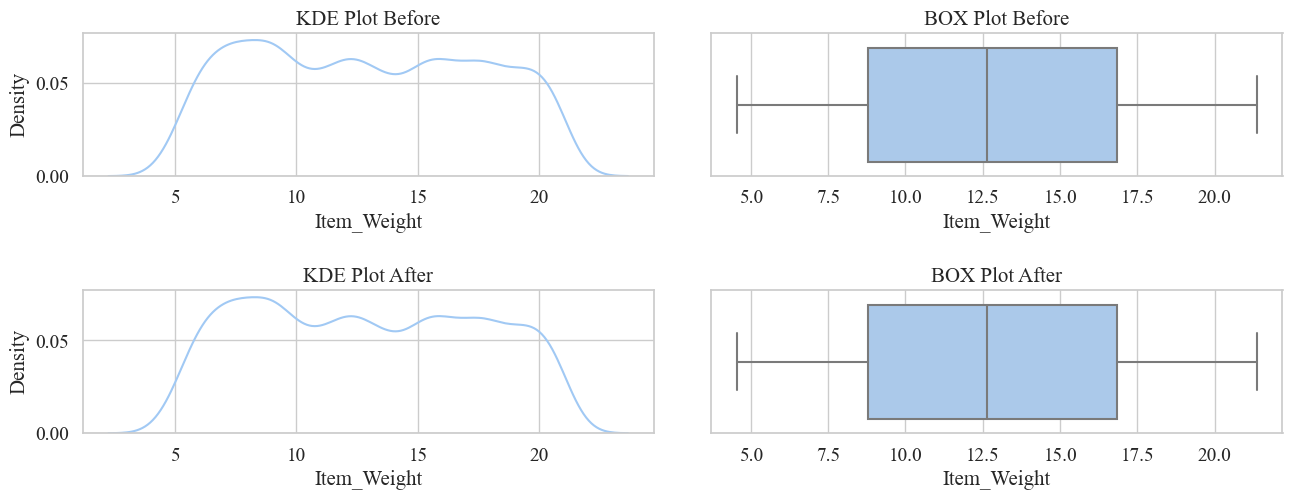






Outlier Detection for Feature : Item_Visibility 

Outliers Summary ........................................................... 

Minimum Value : 0.003574698 and Maximum Value : 0.328390948 

1st Quartile : 0.0330788885 and 3rd Quartile : 0.0945286325 

Lower Bound : -0.0591 and Higher Bound : 0.1867 

No. of Outliers below Lower Bound (-0.0591) are : 0
No. of Outliers above Upper Bound (0.1867) are : 172
Total No. of Outliers are : 172 

Percentage of Outliers Records are : 2.0666 % 

Outliers after Detection and Handling ....................................... 

No. of Outliers below Lower Bound (-0.0591) are : 0
No. of Outliers above Upper Bound (0.1867) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


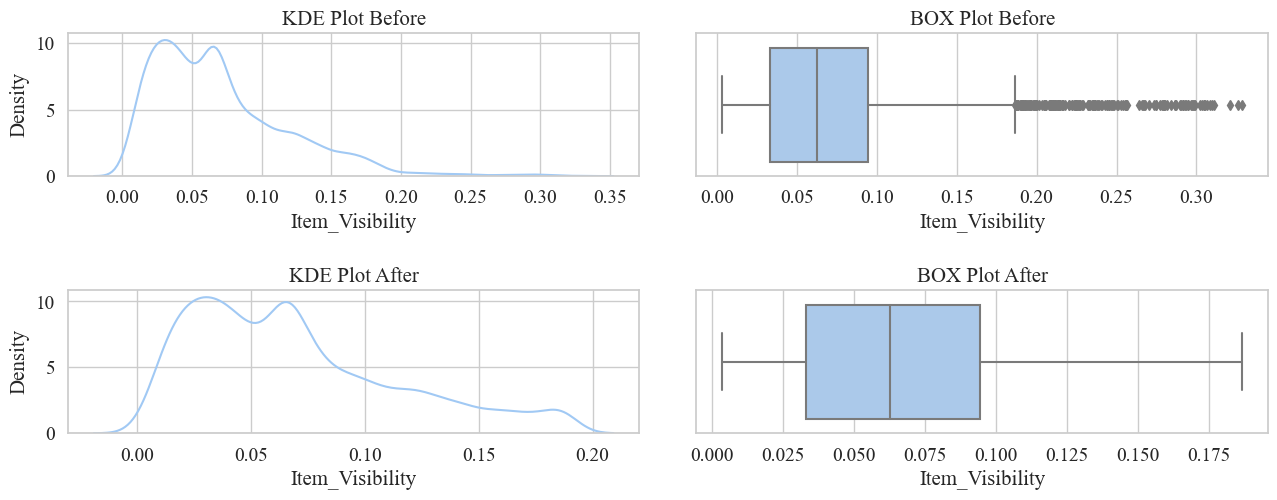






Outlier Detection for Feature : Item_MRP 

Outliers Summary ........................................................... 

Minimum Value : 31.29 and Maximum Value : 266.8884 

1st Quartile : 93.7107 and 3rd Quartile : 185.6437 

Lower Bound : -44.1888 and Higher Bound : 323.5432 

No. of Outliers below Lower Bound (-44.1888) are : 0
No. of Outliers above Upper Bound (323.5432) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 % 

Outliers after Detection and Handling ....................................... 

No. of Outliers below Lower Bound (-44.1888) are : 0
No. of Outliers above Upper Bound (323.5432) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


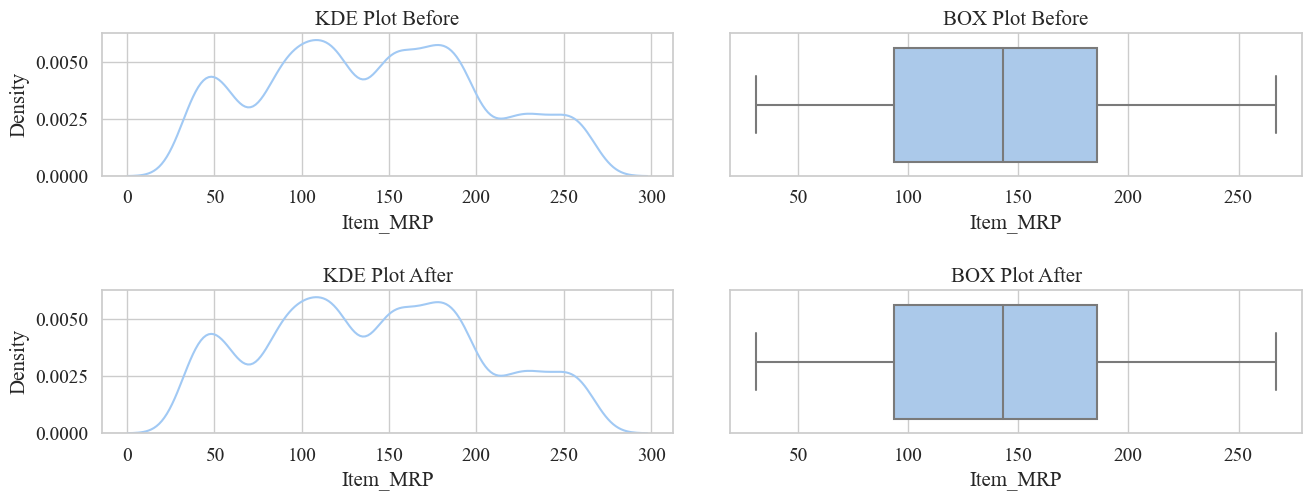






Outlier Detection for Feature : Outlet_Age 

Outliers Summary ........................................................... 

Minimum Value : 4 and Maximum Value : 28 

1st Quartile : 9.0 and 3rd Quartile : 26.0 

Lower Bound : -16.5 and Higher Bound : 51.5 

No. of Outliers below Lower Bound (-16.5) are : 0
No. of Outliers above Upper Bound (51.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 % 

Outliers after Detection and Handling ....................................... 

No. of Outliers below Lower Bound (-16.5) are : 0
No. of Outliers above Upper Bound (51.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


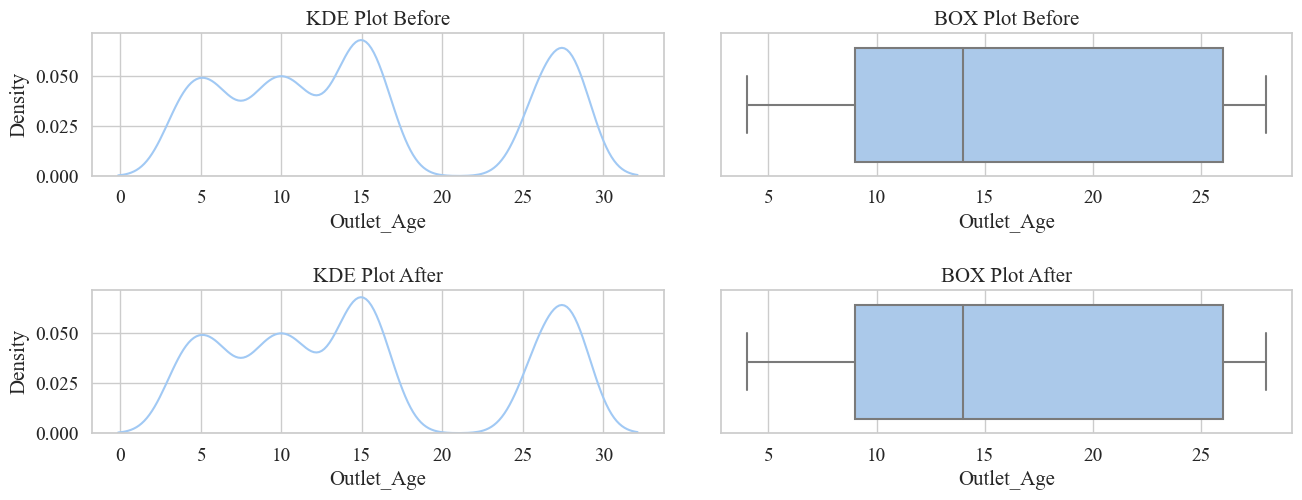

In [11]:
Xtr_out = outliers_detect_handle(Xtr_out)

In [12]:
Xtr_out.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
count,8323.0000,8323.0000,8323.0000,8323.0000
mean,12.8815,0.0692,140.9454,15.1472
std,4.6455,0.0455,62.3287,8.3658
min,4.5550,0.0036,31.2900,4.0000
25%,8.7850,0.0331,93.7107,9.0000
50%,12.6500,0.0625,143.0154,14.0000
75%,16.8500,0.0945,185.6437,26.0000
max,21.3500,0.1867,266.8884,28.0000


In [13]:
### Train dataframe after outlier detection and handling operation, using Xtr_out and ytrain (after balancing)

dftr = pd.concat([Xtr_out,ytr], axis=1)
dftr.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age,Item_Outlet_Sales
2171,13.65,Regular,0.0808,Frozen Foods,262.8936,Medium,Tier 1,Supermarket Type1,Foods,14.0,4958.8784
5657,6.98,Low Fat,0.0412,Canned,82.8934,Small,Tier 2,Supermarket Type1,Foods,11.0,818.9340
2156,20.10,Low Fat,0.0746,Dairy Foods,110.3228,Small,Tier 1,Supermarket Type1,Foods,16.0,1768.3648
110,13.30,Low Fat,0.0798,Dairy Foods,232.5300,Small,Tier 1,Supermarket Type1,Foods,16.0,699.0900
6709,10.10,Non Edible,0.0301,Health and Hygiene,154.3656,Medium,Tier 3,Supermarket Type3,Non Consumables,28.0,2471.4496


##### Saving Final Train CSV File and Pickle Files, after outlier detection and handling step.

In [14]:
print('Writing the dataframes after outlier detection and handling to CSV and PKL files ... \n')

dftr.to_csv('bms_FE_train_final.csv', index=False)
dftr.to_pickle('bms_FE_train_final.pkl')

print('Train File Saved Successfully ...')

Writing the dataframes after outlier detection and handling to CSV and PKL files ... 

Train File Saved Successfully ...


### 3.2 Feature Transformation (to be applied in the model pipeline)

In [15]:
Xtr_ft = Xtr.copy()

#### 3.2.1 Checking transformations on numerical features

In [16]:
from scipy import stats as sts

In [17]:
def trans_skew_kurt(df, fea):
    print(f'Skew: {round(df[fea].skew(),4)} and Kurt {round(df[fea].kurt(),4)}, Before Transformation for "{fea}" \n')
    print(f'Skew and Kurt After Transformation for "{fea}"')
   
    ops = []
    skw_aft = []
    krt_aft = []
    
    dft = df.copy()
    dft[fea] = np.log(dft[fea]+1)                # Log
    ops.append('Log')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    dft = df.copy()
    dft[fea] = dft[fea]**2                       # Square
    ops.append('Square')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    
    dft = df.copy()
    dft[fea] = 1/(dft[fea]+1)                    # Reciprocal
    ops.append('Reciprocal')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    
    dft = df.copy()
    dft[fea] = dft[fea]**(1/2)                   # Square Root
    ops.append('SQRT')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    
    dft = df.copy()
    dft[fea] = dft[fea]**(1/1.2)                   # Exponential 
    ops.append('Exp')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
   
    
    # print(f'Transformation : Box-Cox')           # Box-Cox
    # dft = df.copy()
    # dft[fea], l = sts.boxcox(dft[fea])
    # print(f'Lambda : {round(l,4)}')
    # shape_check_comp(df, dft, fea)

    
    dft = df.copy()
    dft[fea], l = sts.yeojohnson(dft[fea])          # Yeo-Johnson
    ops.append('Yeo-Johnson')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    sk_kr = pd.DataFrame({'Operation':ops,'Skew':skw_aft,'Kurtosis':krt_aft})
    print(sk_kr.sort_values(by=['Skew'], ascending=True))

In [18]:
def shape_check_comp(df, dft, fea):

    plt.figure(figsize=(20,8))
    plt.subplot(2,2,1)
    plt.title('KDE Plot "Before"')
    sb.kdeplot(data=df, x=fea)
    
    plt.subplot(2,2,2)
    plt.title('KDE Plot "After"')
    sb.kdeplot(data=dft, x=fea)
    
    plt.subplot(2,2,3)
    plt.title('QQ-Plot "Before"')
    sts.probplot(df[fea], dist='norm', plot=plt)   # fit=True                   ## QQ-PLOT to check 'normality'
    
    plt.subplot(2,2,4)
    plt.title('QQ-Plot "After"')
    sts.probplot(dft[fea], dist='norm', plot=plt)   # fit=True                   ## QQ-PLOT to check 'normality'

    
    # plt.title('Box Plot')
    # sb.boxplot(data=df, x=fea)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
    
    plt.show()

    print('\n')

In [19]:
def shape_check_all_trans(df, fea):
    
    print(f'Feature Name : {fea} \n')

    print(f'Transformation : Log')
    dft = df.copy()
    dft[fea] = np.log(dft[fea]+1)                # Log
    shape_check_comp(df, dft, fea)       
    
    print(f'Transformation : Square')
    dft = df.copy()
    dft[fea] = dft[fea]**2                       # Square
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Reciprocal')
    dft = df.copy()
    dft[fea] = 1/(dft[fea]+1)                    # Reciprocal
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Square Root')
    dft = df.copy()
    dft[fea] = dft[fea]**(1/2)                   # Square Root
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Exponential')
    dft = df.copy()
    dft[fea] = dft[fea]**(1/1.5)                   # Exponentail
    shape_check_comp(df, dft, fea)
    
    
    # print(f'Transformation : Box-Cox')           # Box-Cox
    # dft = df.copy()
    # dft[fea], l = sts.boxcox(dft[fea])
    # print(f'Lambda : {round(l,4)}')
    # shape_check_comp(df, dft, fea)

    print(f'Transformation : Yeo-Johnson')         # Yeo-Johnson
    dft = df.copy()
    dft[fea], l = sts.yeojohnson(dft[fea])
    print(f'Lambda : {round(l,4)}')
    shape_check_comp(df, dft, fea)

In [20]:
fea_num

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']

In [21]:
Xtr_ft.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
count,8323.0000,8323.0000,8323.0000,8323.0000
mean,12.8815,0.0702,140.9454,15.1472
std,4.6455,0.0488,62.3287,8.3658
min,4.5550,0.0036,31.2900,4.0000
25%,8.7850,0.0331,93.7107,9.0000
50%,12.6500,0.0625,143.0154,14.0000
75%,16.8500,0.0945,185.6437,26.0000
max,21.3500,0.3284,266.8884,28.0000


In [22]:
Xtr_out.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
count,8323.0000,8323.0000,8323.0000,8323.0000
mean,12.8815,0.0692,140.9454,15.1472
std,4.6455,0.0455,62.3287,8.3658
min,4.5550,0.0036,31.2900,4.0000
25%,8.7850,0.0331,93.7107,9.0000
50%,12.6500,0.0625,143.0154,14.0000
75%,16.8500,0.0945,185.6437,26.0000
max,21.3500,0.1867,266.8884,28.0000


In [23]:
# Xtr_ft - ori
# Xtr_out - out handled

In [24]:
trans_skew_kurt(Xtr_ft,'Item_MRP')

Skew: 0.1267 and Kurt -0.8927, Before Transformation for "Item_MRP" 

Skew and Kurt After Transformation for "Item_MRP"
     Operation    Skew  Kurtosis
0          Log -0.7246   -0.3021
3         SQRT -0.2836   -0.7962
5  Yeo-Johnson -0.1159   -0.8795
4          Exp -0.0048   -0.9010
1       Square  0.8066   -0.2484
2   Reciprocal  1.6399    1.9986


In [25]:
trans_skew_kurt(Xtr_out,'Item_MRP')

Skew: 0.1267 and Kurt -0.8927, Before Transformation for "Item_MRP" 

Skew and Kurt After Transformation for "Item_MRP"
     Operation    Skew  Kurtosis
0          Log -0.7246   -0.3021
3         SQRT -0.2836   -0.7962
5  Yeo-Johnson -0.1159   -0.8795
4          Exp -0.0048   -0.9010
1       Square  0.8066   -0.2484
2   Reciprocal  1.6399    1.9986


Feature Name : Item_Weight 

Transformation : Log


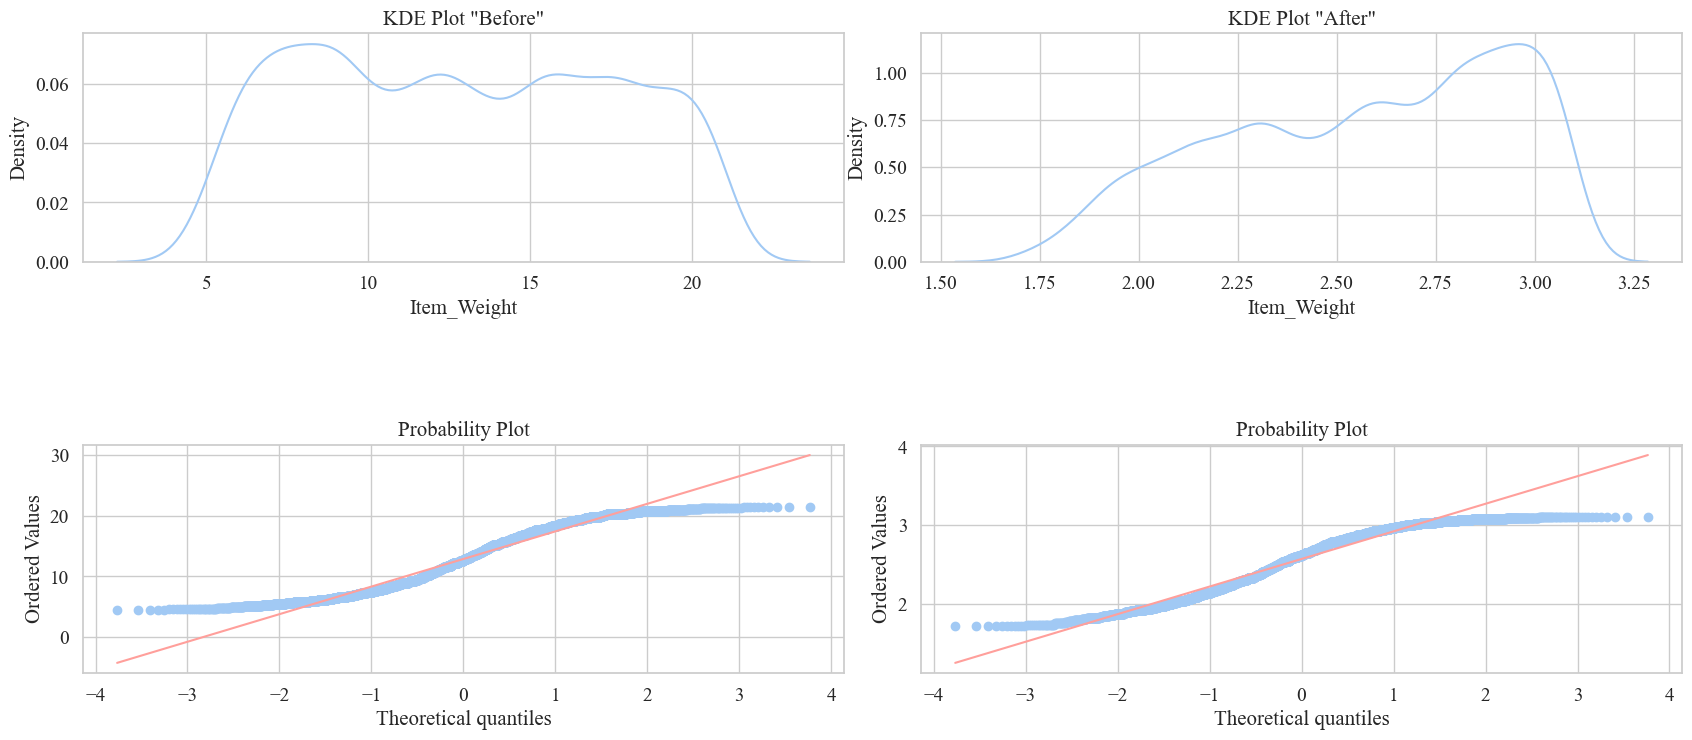



Transformation : Square


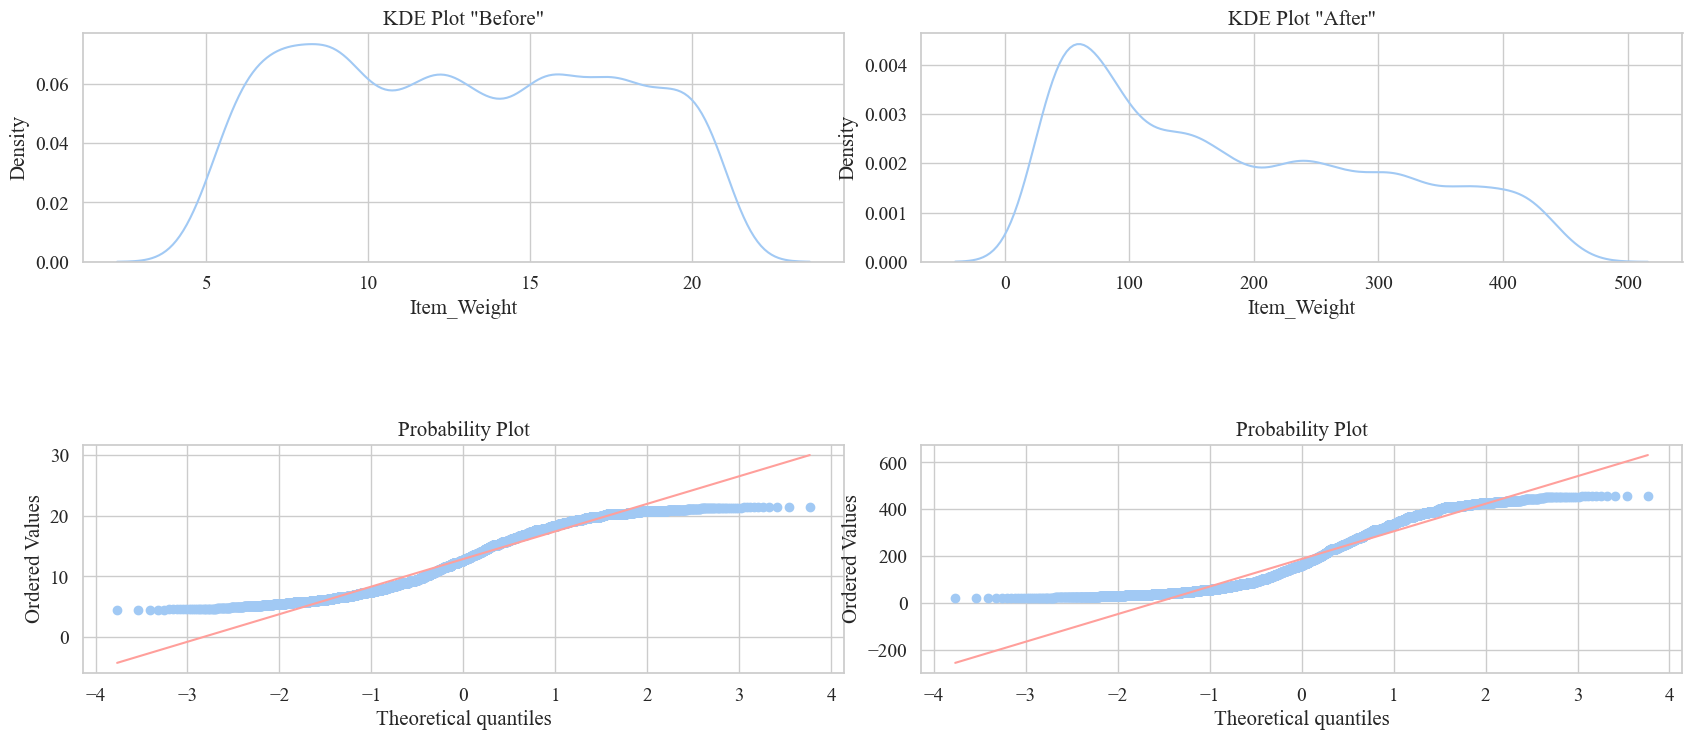



Transformation : Reciprocal


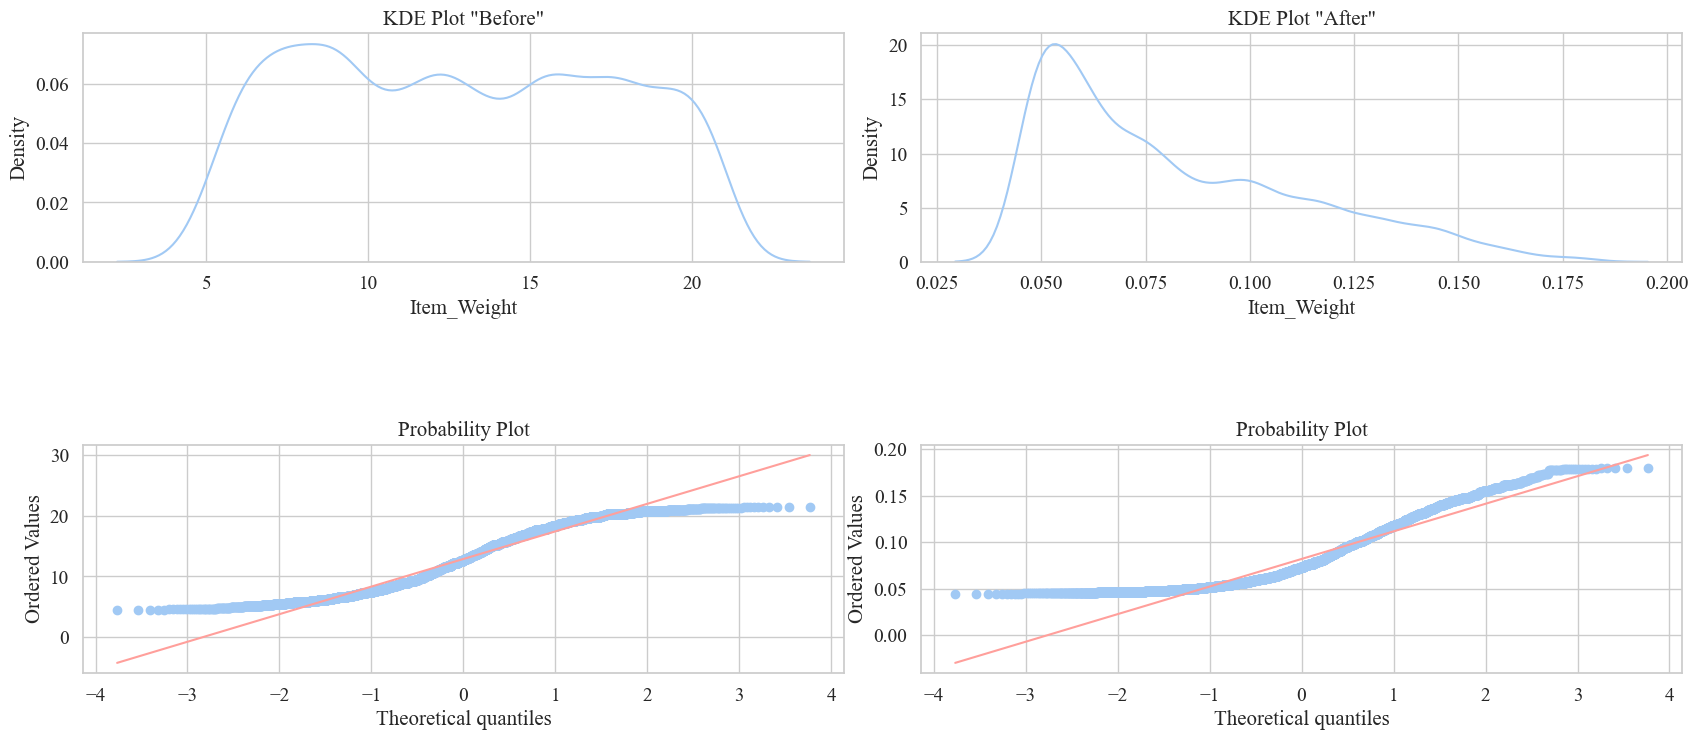



Transformation : Square Root


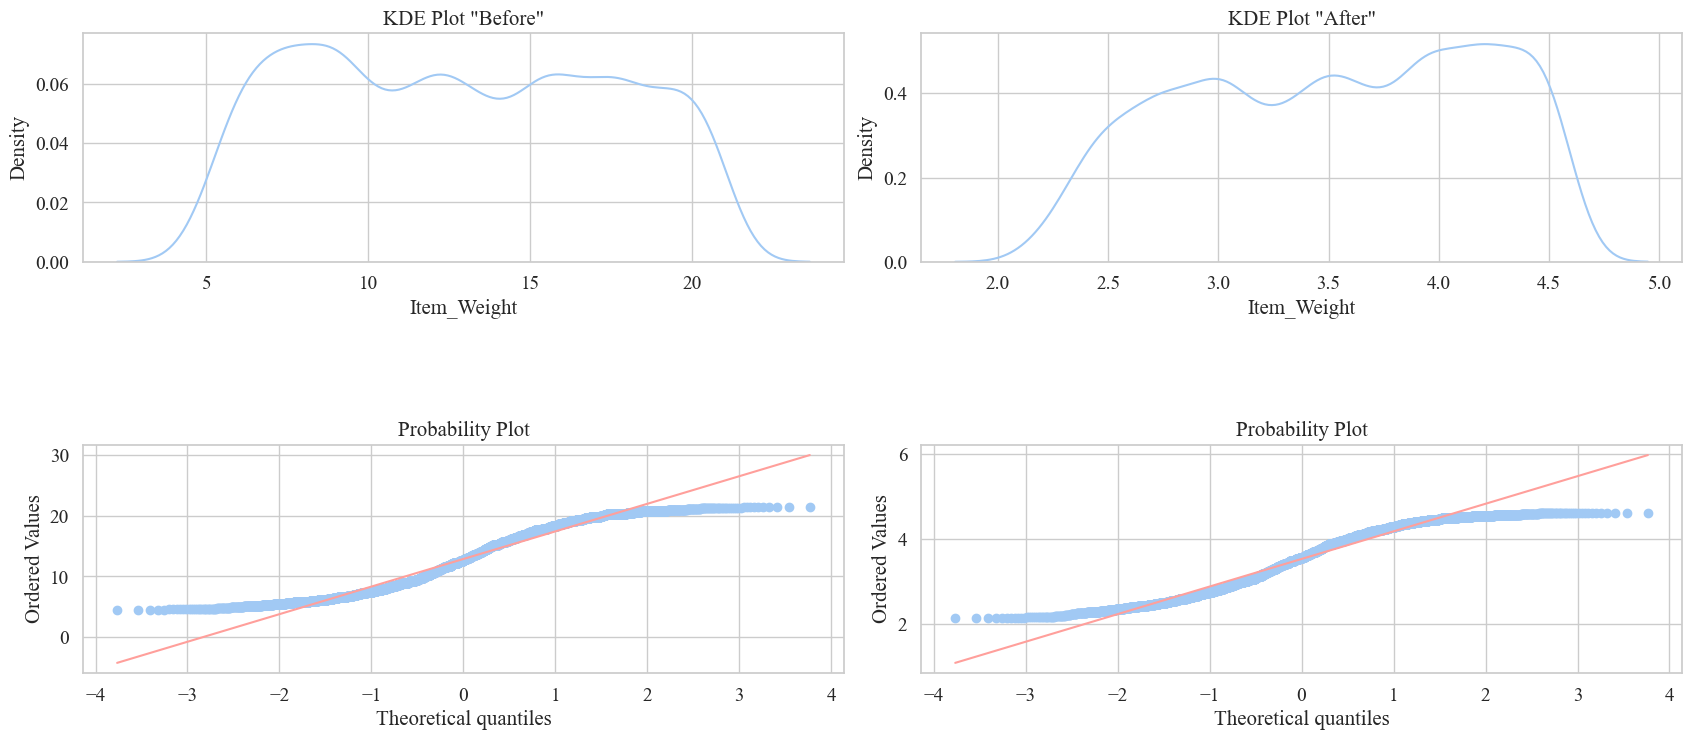



Transformation : Exponential


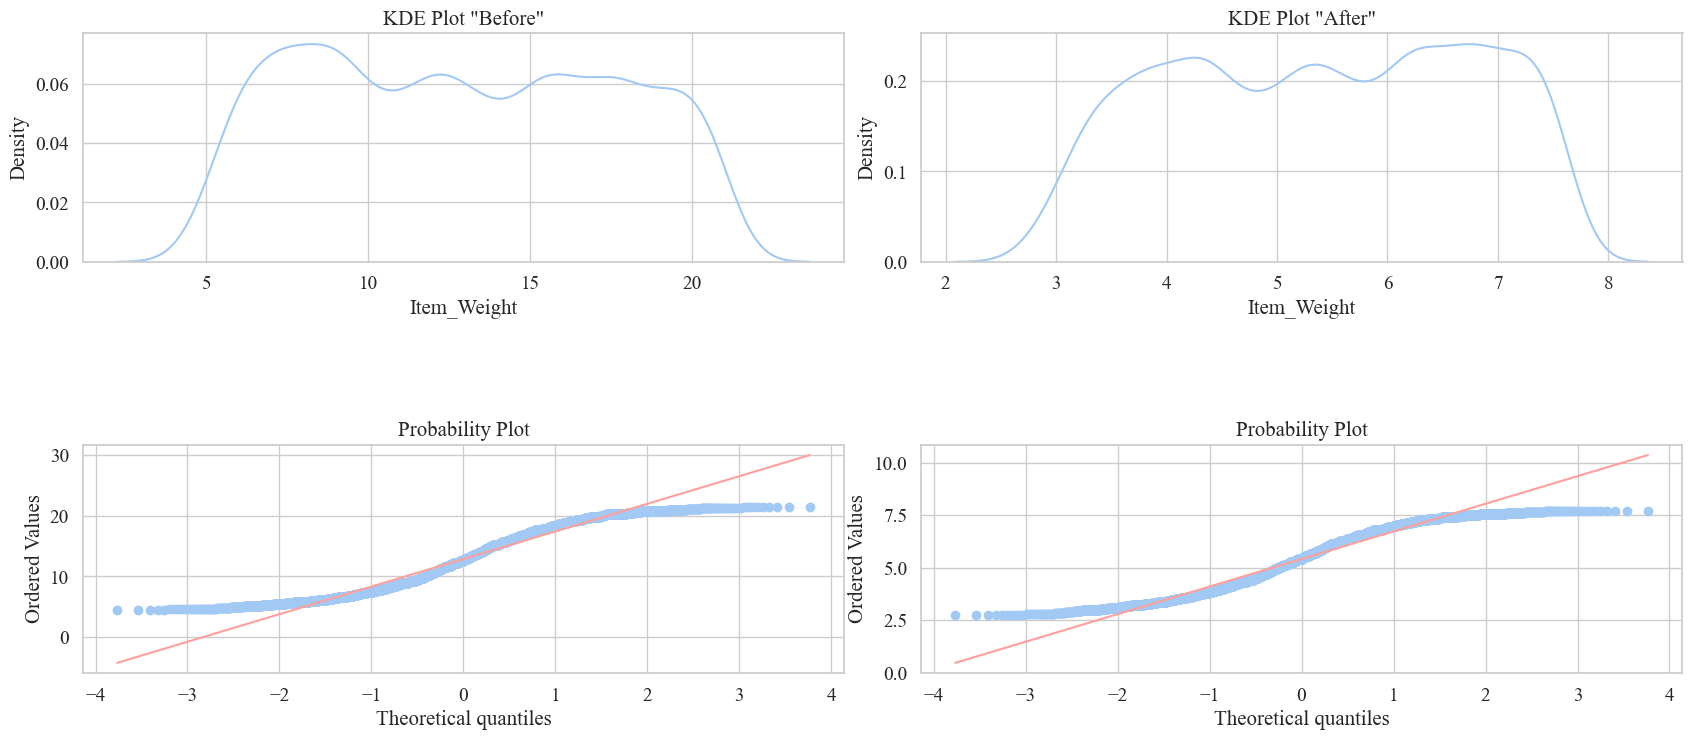



Transformation : Yeo-Johnson
Lambda : 0.6191


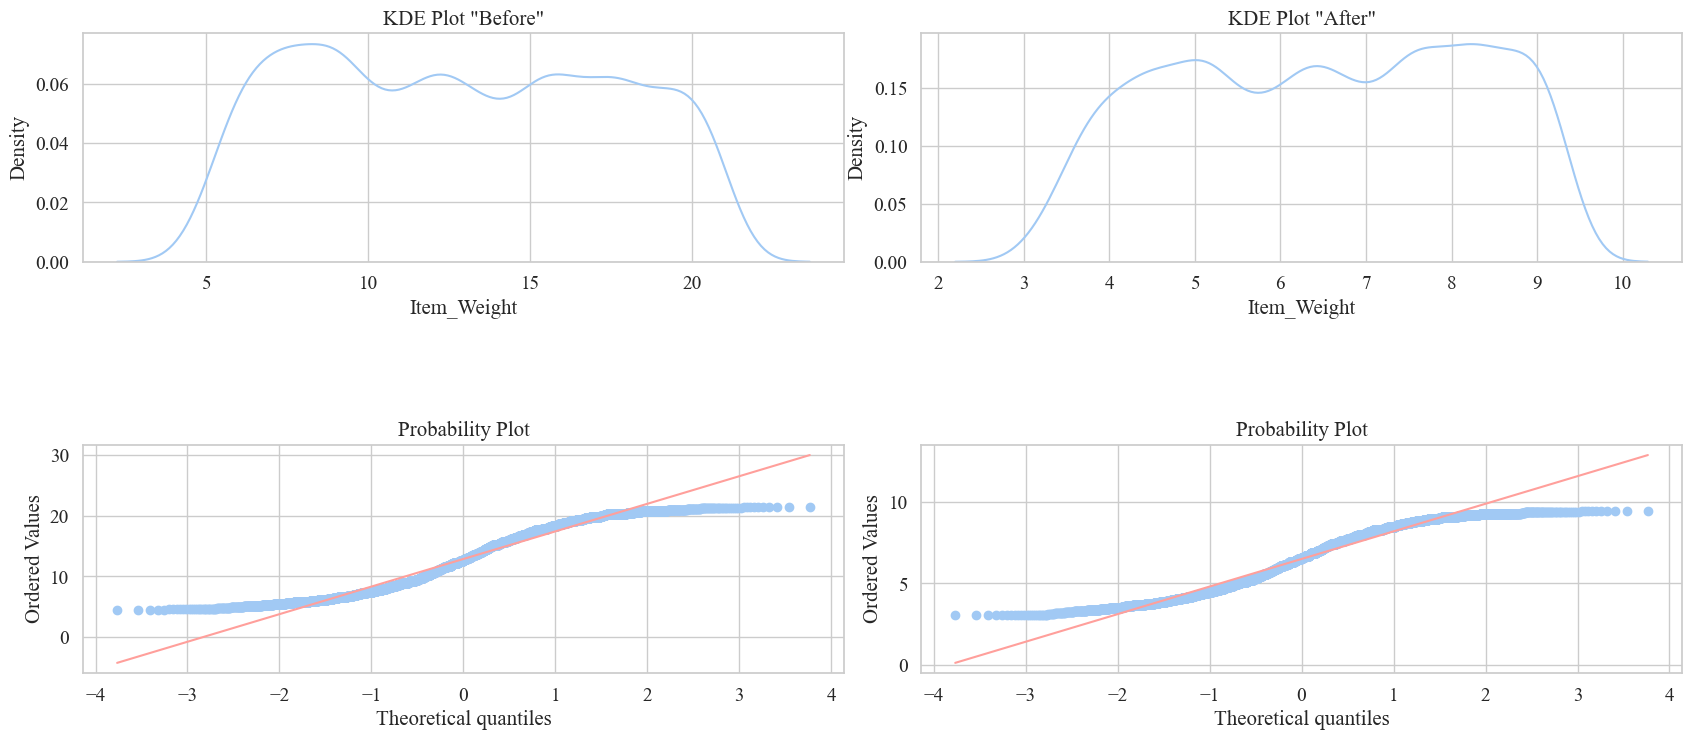

In [26]:
shape_check_all_trans(Xtr_out,'Item_Weight')

## 4. Feature Engineering Pipeline

In [27]:
xdf = Xtr_out.copy()

In [28]:
xdf.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age
2171,13.65,Regular,0.0808,Frozen Foods,262.8936,Medium,Tier 1,Supermarket Type1,Foods,14.0


### 4.1 Numerical Feature Transformation

In [29]:
def ft_exp(df):
    return df.apply(lambda x : x**(1/1.2))


def ft_sqrt(df):
    return df.apply(lambda x : x**(1/2))

ft_mrp_exp = FunctionTransformer(func=ft_exp)
ft_age_sqrt = FunctionTransformer(func=ft_sqrt)

pre_proc_num = ColumnTransformer(transformers=[
                ('pt_it_vis',PowerTransformer(method='yeo-johnson', standardize=False),[2]),
                ('ft_it_mrp',ft_mrp_exp,[4]),
                ('ft_ol_age',ft_age_sqrt,[9])
                ],
                remainder='passthrough')

In [30]:
res_num = pre_proc_num.fit_transform(xdf)
res_num[:1]

array([[0.05551552404293381, 103.86837677515916, 3.7416573867739413,
        13.65, 'Regular', 'Frozen Foods', 'Medium', 'Tier 1',
        'Supermarket Type1', 'Foods']], dtype=object)

### 4.2 Numerical Feature Scaling

In [31]:
pre_proc_ss = ColumnTransformer(transformers=[
                ('ss',StandardScaler(),[0,1,2,3])
                ],
                remainder='passthrough')

In [32]:
res_ss = pre_proc_ss.fit_transform(res_num)
res_ss[:1]

array([[0.4755710080430366, 1.8673582840657776, 0.007850315594022567,
        0.1654307642194026, 'Regular', 'Frozen Foods', 'Medium',
        'Tier 1', 'Supermarket Type1', 'Foods']], dtype=object)

### 4.3 Categorical Data Encoding (Ordinal and OneHot Encoding)

In [33]:
pre_proc_cat = ColumnTransformer(transformers=[
                ('oe',OrdinalEncoder(categories=[['Small','Medium','High'], ['Tier 3','Tier 2','Tier 1'], 
                        ['Grocery Store','Supermarket Type3','Supermarket Type2','Supermarket Type1']], dtype='object'),[6,7,8]),
                ('ohe',OneHotEncoder(drop='first', sparse_output=False, dtype='int8'),[4,5,9]),
                ],
                remainder='passthrough')

In [34]:
res_cat = pre_proc_cat.fit_transform(res_ss)
res_cat[:1]

array([[1, 2, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0.4755710080430366, 1.8673582840657776, 0.007850315594022567,
        0.1654307642194026]], dtype=object)

In [35]:
xdf.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age
2171,13.65,Regular,0.0808,Frozen Foods,262.8936,Medium,Tier 1,Supermarket Type1,Foods,14.0


### 4.4 Feature Selection

In [36]:
fea_select = SelectKBest(mutual_info_regression, k='all')
Xtr_trans = fea_select.fit_transform(res_cat, ytr)

Xtr_trans[:1]

array([[1, 2, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0.4755710080430366, 1.8673582840657776, 0.007850315594022567,
        0.1654307642194026]], dtype=object)

In [37]:
Xtr_trans.shape

(8323, 27)